In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# https://towardsdatascience.com/a-deep-learning-approach-in-predicting-the-next-word-s-7b0ee9341bfe
import nltk
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# read-in cleaned data and parse.
# path = '../data/'
path = '/content/drive/MyDrive/Colab Notebooks/'
filepath = path + 'allphishsets.csv'

df = pd.read_csv(filepath)
df = df.sort_values(by=['showdate', 'set', 'position'],
                    ascending=[True, True, True])

df.loc[df['times_played'] <= 2, 'slug'] = 'wildcard'
df.loc[df['times_played'] <= 2, 'times_played'] = 510

songstring = df[['showdate', 'set', 'slug']].groupby(['showdate', 'set'])['slug']\
                                            .apply(lambda x: '|'.join(x)).reset_index()
songstring['full'] = songstring.apply(lambda row: f"set-{row['set']}|{row['slug']}", axis=1)

songstring = songstring[['showdate', 'full']].groupby(['showdate'])['full']\
                                             .apply(lambda x: '|'.join(x)).reset_index()

songstring['full'] += '|eos'

In [13]:
# NLP the setlists via n-gram model
corpus = [''.join(map(lambda s: s.replace('|', ' '), f))
          for f in songstring['full']]

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
total_unique_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_seqs = token_list[:i+1]
        input_sequences.append(n_gram_seqs)

max_seq_length = max([len(x) for x in input_sequences])
input_seqs = np.array(pad_sequences(input_sequences,
                                    maxlen=max_seq_length, padding='pre'))

x_values, labels = input_seqs[:, :-1], input_seqs[:, -1]
y_values = tf.keras.utils.to_categorical(labels,
                                         num_classes=total_unique_words)

# get directed graph adjacency matrix as embeddings matrix
corpus_list = [
    song for songs in
    [setlist.split(' ') for setlist in corpus]
    for song in songs
]

tw_idx = tokenizer.word_index

embeddings_matrix = np.zeros((total_unique_words, total_unique_words))
for i in trange(len(corpus_list)):
    if i == 0:
        continue
    song_a = tw_idx[corpus_list[i-1]]
    song_b = tw_idx[corpus_list[i]]
    embeddings_matrix[song_a][song_b] += 1

embeddings_matrix += 1
embeddings_matrix = embeddings_matrix / np.sum(embeddings_matrix, axis=1, keepdims=True)

100%|██████████| 39849/39849 [00:00<00:00, 991192.36it/s]


In [15]:
K.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=total_unique_words, output_dim=total_unique_words,
        weights=[embeddings_matrix], input_length=max_seq_length-1,
        trainable=False
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(total_unique_words, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

early_stop = EarlyStopping(
    monitor='val_loss', patience=20, min_delta=0.0001, mode='min',
    start_from_epoch=10, restore_best_weights=True
)

history = model.fit(
    x_values, y_values,
    epochs=120, batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/120
120/120 [==============================] - 21s 108ms/step - loss: 5.2751 - accuracy: 0.0386 - val_loss: 6.1414 - val_accuracy: 0.0431
Epoch 2/120
120/120 [==============================] - 12s 99ms/step - loss: 5.1368 - accuracy: 0.0415 - val_loss: 6.0922 - val_accuracy: 0.0520
Epoch 3/120
120/120 [==============================] - 12s 102ms/step - loss: 4.9906 - accuracy: 0.0484 - val_loss: 6.0831 - val_accuracy: 0.0470
Epoch 4/120
120/120 [==============================] - 13s 105ms/step - loss: 4.8360 - accuracy: 0.0694 - val_loss: 6.0814 - val_accuracy: 0.0821
Epoch 5/120
120/120 [==============================] - 12s 104ms/step - loss: 4.6757 - accuracy: 0.1035 - val_loss: 6.1709 - val_accuracy: 0.0881
Epoch 6/120
120/120 [==============================] - 12s 101ms/step - loss: 4.5887 - accuracy: 0.1193 - val_loss: 6.1194 - val_accuracy: 0.1033
Epoch 7/120
120/120 [==============================] - 12s 103ms/step - loss: 4.4843 - accuracy: 0.1422 - val_loss: 6.0076 - 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 491)           241081    
                                                                 
 bidirectional (Bidirection  (None, 55, 512)           1531904   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 55, 512)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               1574912   
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               6

Text(0.5, 1.0, 'Next Song Accuracy')

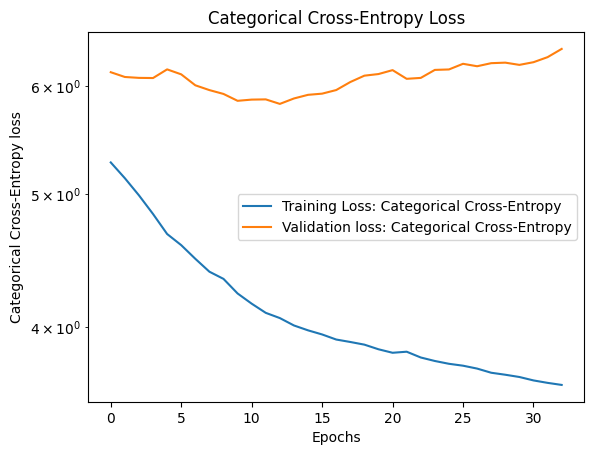

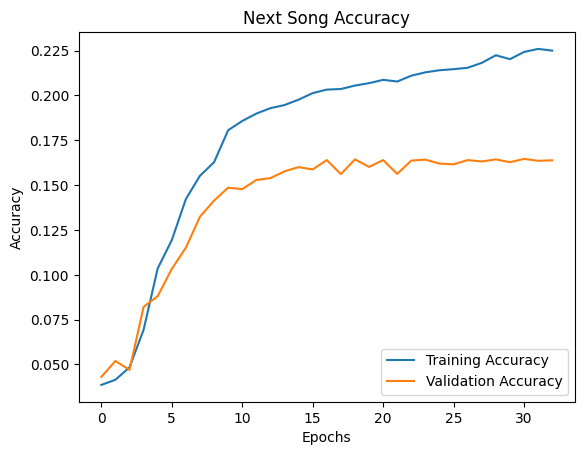

In [24]:
print(model.summary())

loss = 'Categorical Cross-Entropy'

plt.figure()
plt.plot([ l for l in history.history['loss'] ],
         label=f'Training Loss: {loss}')
plt.plot([ l for l in history.history['val_loss'] ],
         label=f'Validation loss: {loss}')

plt.xlabel('Epochs')
plt.ylabel(f'{loss} loss')
plt.yscale('log')
plt.legend(loc='center right')
plt.title(f"{loss} Loss")

plt.figure()
plt.plot([ l for l in history.history['accuracy'] ],
         label=f'Training Accuracy')
plt.plot([ l for l in history.history['val_accuracy'] ],
         label=f'Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel(f'Accuracy')
# plt.yscale('log')
plt.legend(loc='lower right')
plt.title("Next Song Accuracy")